# Dashboard to look at impact tracker results for various experiment sets

## Datasets
- ukb pilot [cohort](https://github.com/neurodatascience/watts_up_compute/blob/impact_tracker/subject_lists/ukb_pilot_subjects.csv)

## Pipelines
- FreeSurfer: recon-all (1,2,3 stages)
- FastSurfer: FastSurferCNN (volumetric segmentation)

## Monitoring metrics
- experiment duration in hours
- power consumption in kWh (kilo-watt-hours) 

In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *
from experiment_impact_tracker.data_utils import (load_data_into_frame,
                                                  load_initial_info,
                                                  zip_data_and_info)

from lib.dashboard_utils import *

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=429.61 Hz, eta=0:00:00, total=0:00:01, wall=16:17 EST
Done!


In [2]:
project_dir = '../'
fastsurfer_exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
preproc_exp_dir = '{}/preproc_pipeline_experiments/'.format(project_dir)
fastsurfer_results_dir = '{}results/exp_impact_tracker/'.format(fastsurfer_exp_dir)
preproc_results_dir = '{}results/exp_impact_tracker/'.format(preproc_exp_dir)
subject_lists = '{}subject_lists/ukb_pilot_subjects.csv'.format(project_dir)

### Custom set of trial expeirments

In [15]:
experiment_dict = {
                   'FastSurfer_local_cpu':('{}/track_sub_000_benchmark/'.format(fastsurfer_results_dir),False), 
                   'FastSurfer_CC_cpu':('{}/CC_cpu_test/'.format(fastsurfer_results_dir),False),
                   'FastSurfer_CC_gpu':('{}/CC_gpu_test/'.format(fastsurfer_results_dir),True),
                   'autorecon1_local_test_1':('{}/ReconAll_test_local_cpu/'.format(preproc_results_dir),False),
                   'autorecon2-3_local_test_1':('{}/ReconAll_test_location_override/'.format(preproc_results_dir),False),
                   'autorecon1_CC_test_1':('{}/ReconAll_test_CC_cpu/'.format(preproc_results_dir),False),
                   'autorecon1_CC_ukb_1':('{}/ReconAll_ukb_CC_cpu/'.format(preproc_results_dir),False)
                   }

read_flops = True

power_df_concat = pd.DataFrame()
flops_df_concat = pd.DataFrame()
tracker_summary_df_concat = pd.DataFrame()

for k,v in experiment_dict.items():
    power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1], read_flops)
    power_df_concat = power_df_concat.append(power_df)
    flops_df_concat = flops_df_concat.append(flops_df)
    tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)


number of timestamps: 2633
total_power sanity check: default: 0.06703, calculated: 0.06703, 0.06703
number of timestamps: 940
total_power sanity check: default: 0.13523, calculated: 0.13523, 0.13523
number of timestamps: 8
total_power sanity check: default: 0.00225, calculated: 0.00225, 0.00225
number of timestamps: 240
total_power sanity check: default: 0.00445, calculated: 0.00445, 0.00445
number of timestamps: 6808
total_power sanity check: default: 0.08423, calculated: 0.08423, 0.08423
number of timestamps: 332
total_power sanity check: default: 0.00381, calculated: 0.00381, 0.00381
number of timestamps: 239
total_power sanity check: default: 0.02303, calculated: 0.02303, 0.02303


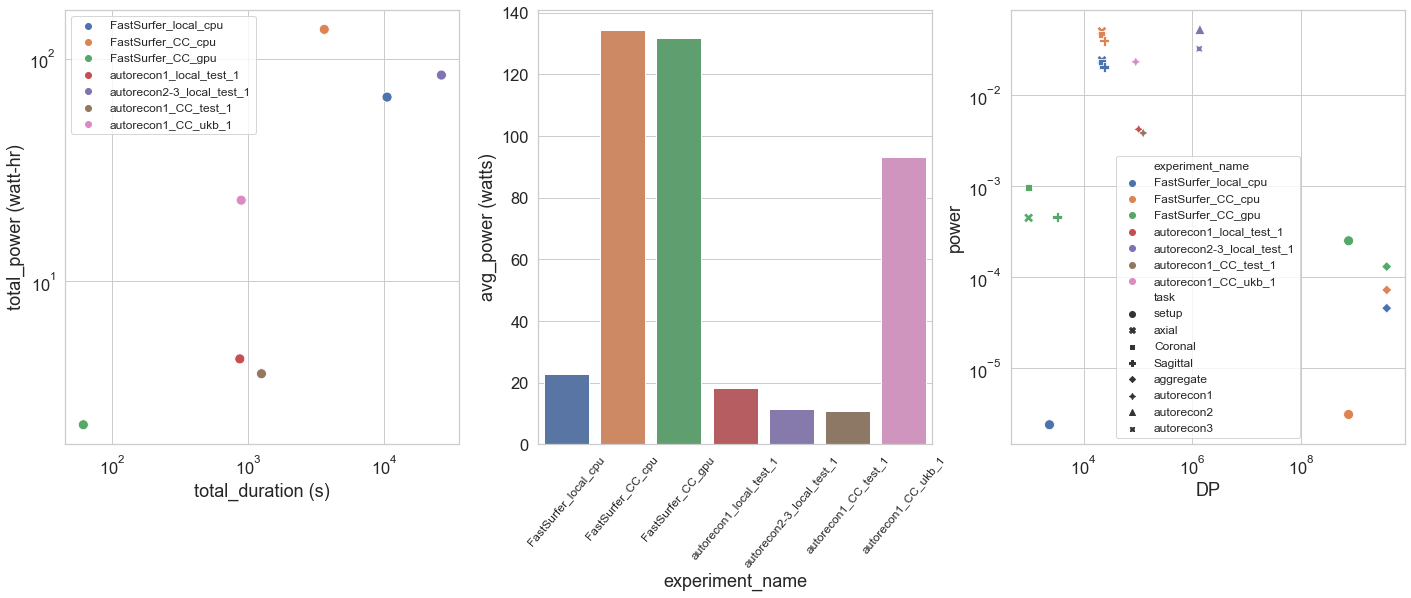

In [24]:
plot_df = tracker_summary_df_concat.copy()
plot_df['total_duration (s)'] = plot_df['total_duration'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,3, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_name', s=100, data=plot_df, ax=ax)
    g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_name', data=plot_df, ax=ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=50,fontsize=12)

    ax = axes[2]
    plot_df = flops_df_concat.copy()
    g = sns.scatterplot(y='power', x='DP', hue='experiment_name', style='task', s=100, data=plot_df, ax=ax)
    g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

### UKB pilot experiment sets
- recon-all 
- fastsurfer
    - pruning_{0,25,50}
    - gpu/cpu

In [3]:
save_perf = False

subject_df = pd.read_csv(subject_lists)
subject_ids = subject_df['eid']

ignore_subjects = {0} #{1009760}
subject_ids = list(set(subject_ids) - ignore_subjects)

print('Found {} subjects'.format(len(subject_ids)))

experiment_sets = {
                #    'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda
                   'fastsurfer_gpu_prune_0':(fastsurfer_results_dir + 'ukb/gpu/prune_0/', True) # log_dir, use_cuda
                  }

for exp_name, exp_config in experiment_sets.items(): 
    tracker_log_dir = exp_config[0]
    use_cuda = exp_config[1]
    tracker_summary_df_concat, flops_df_concat, power_df_concat = collate_tracker_data(tracker_log_dir, subject_ids, use_cuda)
    tracker_summary_df_concat['experiment_set'] = exp_name
    flops_df_concat['experiment_set'] = exp_name
    power_df_concat['experiment_set'] = exp_name
    
    if save_perf:
        tracker_summary_df_concat.to_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
        flops_df_concat.to_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
        power_df_concat.to_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))


Found 4 subjects
No valid experiment impact tracker log found for: 0 at ..//FastSurfer_experiments/results/exp_impact_tracker/ukb/gpu/prune_0/sub-0/
number of timestamps: 6
number of timestamps: 6
number of timestamps: 7
total_power sanity check: default: 0.00262, calculated: 0.00262, 0.00262
total_power sanity check: default: 0.00262, calculated: 0.00262, 0.00262
total_power sanity check: default: 0.00253, calculated: 0.00253, 0.00253


In [4]:
tracker_summary_df_concat

,experiment_name,total_power,total_carbon,PUE,total_duration_papi,total_duration_impact_tracker,experiment_set
0,1047553.0,0.002622,0.000079,1.58,0.017729,0.012923,fastsurfer_gpu_prune_0
0,3553027.0,0.002527,0.000076,1.58,0.017729,0.014419,fastsurfer_gpu_prune_0
0,1406980.0,0.002621,0.000079,1.58,0.017729,0.012695,fastsurfer_gpu_prune_0


### Collate saved tracker perf

In [5]:
tracker_summary_df_concat_exp_set = pd.DataFrame()
flops_df_concat_exp_set = pd.DataFrame()
power_df_concat_exp_set = pd.DataFrame()

experiment_sets = {
                   'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda
                   'fastsurfer_gpu_prune_0':(fastsurfer_results_dir + 'ukb/gpu/', True) # log_dir, use_cuda
                  }

for exp_name, exp_config in experiment_sets.items(): 
    tracker_log_dir = exp_config[0]
    tracker_summary_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
    flops_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
    power_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))

    tracker_summary_df_concat_exp_set = tracker_summary_df_concat_exp_set.append(tracker_summary_df_concat)
    flops_df_concat_exp_set = flops_df_concat_exp_set.append(flops_df_concat)
    power_df_concat_exp_set = power_df_concat_exp_set.append(power_df_concat)


## Plots
### Duration

### Total power usage per experiment (i.e. subject)

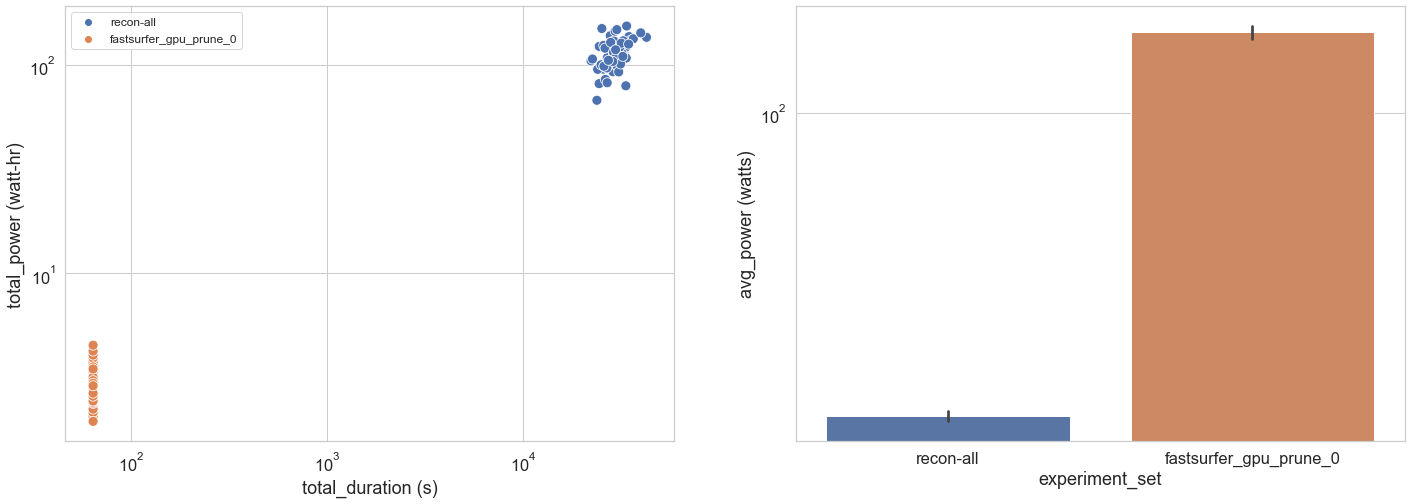

In [11]:
plot_df = tracker_summary_df_concat_exp_set.copy()
plot_df['total_duration (s)'] = plot_df['total_duration'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,2, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_set', s=100, data=plot_df, ax=ax)
    g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_set', data=plot_df, ax=ax)
    # g.set_xticklabels(g.get_xticklabels(),rotation=50,fontsize=12)
    g.set(yscale='log') 



### Power for segmentation

Before grouping: number of rows for recon task subset: 144, fastsurfer subset: 360
After grouping: number of rows for recon task subset: 72, fastsurfer subset: 72


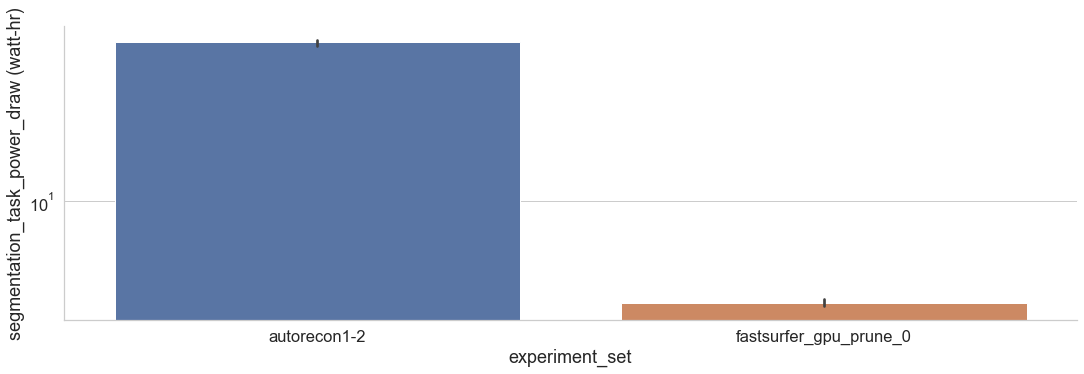

In [15]:
recon_df = flops_df_concat_exp_set[flops_df_concat_exp_set['task'].isin(['autorecon1','autorecon2'])].copy()
fastsurfer_df = flops_df_concat_exp_set[flops_df_concat_exp_set['experiment_set'].isin(['fastsurfer_gpu_prune_0'])].copy()
print('Before grouping: number of rows for recon task subset: {}, fastsurfer subset: {}'.format(len(recon_df),len(fastsurfer_df)))

recon_df = recon_df.groupby(['experiment_name']).sum().reset_index()
recon_df['experiment_set'] = 'autorecon1-2'

fastsurfer_df = fastsurfer_df.groupby(['experiment_name']).sum().reset_index()
fastsurfer_df['experiment_set'] = 'fastsurfer_gpu_prune_0'
print('After grouping: number of rows for recon task subset: {}, fastsurfer subset: {}'.format(len(recon_df),len(fastsurfer_df)))

plot_df = recon_df.append(fastsurfer_df)
plot_df['segmentation_task_power_draw (watt-hr)'] = plot_df['power']*1000

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='segmentation_task_power_draw (watt-hr)', x='experiment_set', data=plot_df, kind='bar',aspect=3)
    g.set(yscale='log')



### avg power reading

In [ ]:
plot_df = power_df_concat_exp_set.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='total_power_per_timestep', x='experiment_name', hue='experiment_set', data=plot_df, kind='point',aspect=3)
    g.set_xticklabels(rotation=50,fontsize=12)


### Flops vs Power

In [ ]:
plot_df = flops_df_concat_exp_set.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,10),sharex=False,sharey=False)
    g = sns.scatterplot(y='power', x='DP', hue='task', s=100, data=plot_df)
    g.set(xscale='log') 


### Power trace

In [ ]:
experiment_set =  'recon-all' #'recon-all' #'fastsurfer_gpu_prune_0'
experiment_name = 1474044
use_cuda = True
plot_epochs = False

plot_df = power_df_concat_exp_set[(power_df_concat_exp_set['experiment_set']==experiment_set) & (power_df_concat_exp_set['experiment_name']==experiment_name)].copy()
total_power = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['total_power'].values[0]
PUE = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['PUE'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(plot_df['timestamp'],plot_df['total_power_per_timestep'].cumsum(),label='total attributed_power')

    if plot_epochs: 
        for e in epochs:
            g = plt.axvline(e, linestyle='-',c='purple')
        
    g = plt.axhline(total_power, linestyle='--',c='black',label='total power estimate')
    
    plt.ylabel('power_draws')
    plt.legend()
